## Explore one-hit vs. two-hit samples in expression space

In [1]:
from pathlib import Path
import pickle as pkl

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import sys; sys.path.append('..')
import config as cfg
from data_utilities import load_cnv_data

%load_ext autoreload
%autoreload 2

In [2]:
# park et al. geneset info
park_loss_data = cfg.data_dir / 'park_loss_df.tsv'
park_gain_data = cfg.data_dir / 'park_gain_df.tsv'

# park et al. significant gene info
park_loss_sig_data = cfg.data_dir / 'park_loss_df_sig_only.tsv'
park_gain_sig_data = cfg.data_dir / 'park_gain_df_sig_only.tsv'

# park et al. gene/cancer type predictions
park_preds_dir = cfg.data_dir / 'park_genes_all_preds'

# mutation and copy number data
pancancer_pickle = Path('/home/jake/research/mpmp/data/pancancer_data.pkl')

# gene expression/rppa data files
data_type = 'gene expression'
subset_feats = 10000
gene_expression_data_file = Path(
    '/home/jake/research/mpmp/data/tcga_expression_matrix_processed.tsv.gz'
)
rppa_data_file = Path(
    '/home/jake/research/mpmp/data/tcga_rppa_matrix_processed.tsv'
)

### Load mutation info

For now, just use binary mutation status from the pancancer repo. In the future we could pull more granular info from MC3, but it would take some engineering of `1_get_mutation_counts` to do this for lots of genes.

In [3]:
park_loss_df = pd.read_csv(park_loss_data, sep='\t', index_col=0)
park_loss_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
ACVR1_UCEC,ACVR1,UCEC,0.000000,0.997445,0.681521,0.166514,B_Target,Oncogene
ACVR2A_COADREAD,ACVR2A,COADREAD,0.000000,0.997631,0.681315,0.166646,B_Target,TSG
ACVR2A_LIHC,ACVR2A,LIHC,-1.000178,0.040008,0.122307,0.912515,B_Target,TSG
AJUBA_HNSC,AJUBA,HNSC,-0.936050,0.008733,0.045816,1.338886,A_Hit,TSG
AKT1_BRCA,AKT1,BRCA,0.000000,0.997163,0.681829,0.166318,B_Target,Oncogene


In [4]:
park_gain_df = pd.read_csv(park_gain_data, sep='\t', index_col=0)
park_gain_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
ACVR1_UCEC,ACVR1,UCEC,-0.482699,0.370095,0.571956,0.242630,B_Target,Oncogene
ACVR2A_COADREAD,ACVR2A,COADREAD,0.187531,0.753981,0.780954,0.107369,B_Target,TSG
ACVR2A_LIHC,ACVR2A,LIHC,0.163421,0.834858,0.821548,0.085362,B_Target,TSG
AJUBA_HNSC,AJUBA,HNSC,0.711518,0.026392,0.147049,0.832509,B_Target,TSG
AKT1_BRCA,AKT1,BRCA,0.535765,0.092176,0.312738,0.504805,B_Target,Oncogene


In [5]:
with open(pancancer_pickle, 'rb') as f:
    pancancer_data = pkl.load(f)

In [6]:
# get (binary) mutation data
# 1 = observed non-silent mutation in this gene for this sample, 0 otherwise
mutation_df = pancancer_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


### Load copy number info

Get copy loss/gain info directly from GISTIC "thresholded" output. This should be the same as (or very similar to) what the Park et al. study uses.

In [7]:
sample_freeze_df = pancancer_data[0]
copy_samples = set(sample_freeze_df.SAMPLE_BARCODE)
print(len(copy_samples))

9074


In [8]:
copy_loss_df, copy_gain_df = load_cnv_data(
    cfg.data_dir / 'pancan_GISTIC_threshold.tsv',
    copy_samples
)
print(copy_loss_df.shape)
copy_loss_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,1,1,1,1,1
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [9]:
print(copy_gain_df.shape)
copy_gain_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,1,1,1,1,1
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [10]:
sample_freeze_df.head()

,PATIENT_BARCODE,SAMPLE_BARCODE,DISEASE,SUBTYPE
0,TCGA-OR-A5J1,TCGA-OR-A5J1-01,ACC,Not_Applicable
1,TCGA-OR-A5J2,TCGA-OR-A5J2-01,ACC,Not_Applicable
2,TCGA-OR-A5J3,TCGA-OR-A5J3-01,ACC,Not_Applicable
3,TCGA-OR-A5J5,TCGA-OR-A5J5-01,ACC,Not_Applicable
4,TCGA-OR-A5J6,TCGA-OR-A5J6-01,ACC,Not_Applicable


### Load expression data

We'll also standardize each feature, and subset to the top features by mean absolute deviation if `subset_feats` is set.

In [11]:
if data_type == 'gene expression':
    exp_df = pd.read_csv(gene_expression_data_file, sep='\t', index_col=0)
elif data_type == 'rppa':
    exp_df = pd.read_csv(rppa_data_file, sep='\t', index_col=0)
    
print(exp_df.shape)
exp_df.iloc[:5, :5]

(11060, 15369)


,1,100,1000,10000,10001
sample_id,,,,,
TCGA-02-0047-01,125.0,136.0,2300.0,1300.0,272.0
TCGA-02-0055-01,392.0,222.0,1820.0,903.0,321.0
TCGA-02-2483-01,272.0,256.0,2890.0,1320.0,458.0
TCGA-02-2485-01,83.9,129.0,6970.0,10100.0,419.0
TCGA-02-2486-01,108.0,205.0,2250.0,873.0,441.0


In [12]:
# standardize features first
exp_df = pd.DataFrame(
    StandardScaler().fit_transform(exp_df),
    index=exp_df.index.copy(),
    columns=exp_df.columns.copy()
)
print(exp_df.shape)
exp_df.iloc[:5, :5]

(11060, 15369)


,1,100,1000,10000,10001
sample_id,,,,,
TCGA-02-0047-01,-0.144025,-0.206544,1.029891,0.643947,-0.730368
TCGA-02-0055-01,-0.124850,-0.132174,0.689587,0.153994,-0.406662
TCGA-02-2483-01,-0.133468,-0.102772,1.448180,0.668630,0.498391
TCGA-02-2485-01,-0.146976,-0.212598,4.340760,11.504372,0.240748
TCGA-02-2486-01,-0.145246,-0.146875,0.994442,0.116970,0.386085


In [13]:
# subset to subset_feats features by mean absolute deviation
if subset_feats is not None:
    mad_ranking = (
        exp_df.mad(axis=0)
               .sort_values(ascending=False)
    )
    top_feats = mad_ranking[:subset_feats].index.astype(str).values
    exp_mad_df = exp_df.reindex(top_feats, axis='columns')
else:
    exp_mad_df = exp_df
    
print(exp_mad_df.shape)
exp_mad_df.iloc[:5, :5]

(11060, 10000)


,126695,10053,147798,54845,582
sample_id,,,,,
TCGA-02-0047-01,-1.312480,-1.124171,-0.980741,-1.115484,0.461693
TCGA-02-0055-01,-1.310389,-1.116947,-0.967446,-1.113075,-0.549801
TCGA-02-2483-01,-1.312480,-1.124171,-0.987583,-1.115567,-0.468503
TCGA-02-2485-01,-1.310706,-1.123449,-0.987619,-1.112268,1.104512
TCGA-02-2486-01,-1.310207,-1.124171,-0.986505,-1.115828,1.009980


### Get sample info and hit groups for gene/cancer type

In [14]:
def get_hits_for_gene_and_tissue(identifier, cancer_classification):
    """Given a gene and tissue, load the relevant mutation/CNV information,
    and divide the samples into groups to compare survival.
    """
    # get patient ids in given cancer type 
    gene, tissue = identifier.split('_')
    tissue_ids = (sample_freeze_df
        .query('DISEASE == @tissue')
        .SAMPLE_BARCODE
    )
    
    # get mutation and copy status
    mutation_status = mutation_df.loc[tissue_ids, gene]
    if cancer_classification == 'TSG':
        copy_status = copy_loss_df.loc[tissue_ids, gene]
    elif cancer_classification == 'Oncogene':
        copy_status = copy_gain_df.loc[tissue_ids, gene]
        
    # get hit groups from mutation/CNV data
    two_hit_samples = (mutation_status & copy_status).astype(int)
    one_hit_samples = (mutation_status | copy_status).astype(int)
        
    return pd.DataFrame(
        {'group': one_hit_samples + two_hit_samples}
    )

In [15]:
identifier = 'ATRX_LGG'
cancer_classification = 'Oncogene'

sample_mut_df = get_hits_for_gene_and_tissue(identifier, cancer_classification)

# make sure sample data overlaps exactly with expression data
overlap_ixs = sample_mut_df.index.intersection(exp_mad_df.index)
sample_mut_df = sample_mut_df.loc[overlap_ixs, :].copy()
exp_mad_df = exp_mad_df.loc[overlap_ixs, :].copy()

# add group info for legends
sample_mut_df['group'] = sample_mut_df.group.map({
    0: 'wild-type',
    1: 'one-hit',
    2: 'two-hit'
})

print(sample_mut_df.shape)
print(sample_mut_df.group.unique())
sample_mut_df.iloc[:5, :5]

(507, 1)
['wild-type' 'two-hit' 'one-hit']


,group
TCGA-CS-6669-01,wild-type
TCGA-CS-4938-01,two-hit
TCGA-CS-4941-01,wild-type
TCGA-CS-4942-01,one-hit
TCGA-CS-4943-01,one-hit


### Plot samples by hit group

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_proj_pca = pca.fit_transform(exp_mad_df)

print(X_proj_pca.shape)
X_proj_pca[:5, :5]

(507, 2)


array([[ 70.23106561, 100.77223527],
       [ -5.72402311,  -5.49102169],
       [-15.47242332,  -0.62594851],
       [  2.69242384,  -8.31427553],
       [  7.11252463, -33.41292812]])

Text(0, 0.5, 'PC2')

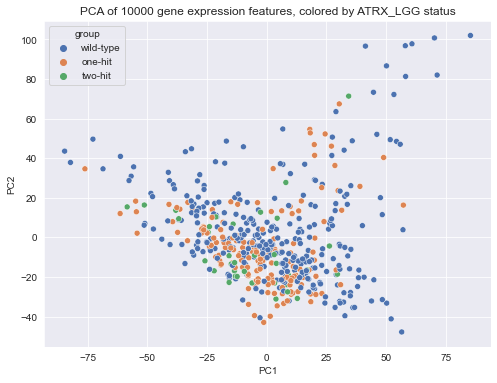

In [17]:
sns.set({'figure.figsize': (8, 6)})

sns.scatterplot(x=X_proj_pca[:, 0],
                y=X_proj_pca[:, 1],
                hue=sample_mut_df.group,
                hue_order=['wild-type', 'one-hit', 'two-hit'])

plt.title('PCA of {} {} features, colored by {} status'.format(
    subset_feats, data_type, identifier))
plt.xlabel('PC1')
plt.ylabel('PC2')

In [18]:
from umap import UMAP

reducer = UMAP(n_components=2, random_state=42)

X_proj_umap = reducer.fit_transform(exp_mad_df)

print(X_proj_umap.shape)
X_proj_umap[:5, :5]

/home/jake/anaconda3/envs/mutation_fn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(507, 2)


array([[ 5.592694,  4.120277],
       [ 9.03526 ,  9.526029],
       [ 8.659716,  6.640526],
       [ 9.346365,  9.929928],
       [ 8.895314, 11.924898]], dtype=float32)

Text(0, 0.5, 'UMAP2')

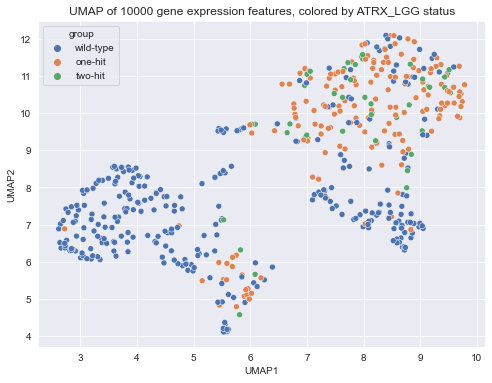

In [19]:
sns.set({'figure.figsize': (8, 6)})

sns.scatterplot(x=X_proj_umap[:, 0],
                y=X_proj_umap[:, 1],
                hue=sample_mut_df.group,
                hue_order=['wild-type', 'one-hit', 'two-hit'])

plt.title('UMAP of {} {} features, colored by {} status'.format(
    subset_feats, data_type, identifier))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

### Plot samples by hit group, using features selected by pan-cancer classifiers

In [20]:
coefs_file = Path(
    '/home/jake/research/mpmp/data/final_models/final_expression_all_merged_coefs.tsv'
)

coefs_df = pd.read_csv(coefs_file, sep='\t', index_col=0)
coefs_df.iloc[:5, :5]

/home/jake/anaconda3/envs/mutation_fn/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ABL2,ACVR2A,AFF3,ALK,AMER1
1,NaN,NaN,NaN,NaN,NaN
100,0.0,NaN,0.0,NaN,NaN
1000,0.0,0.0,0.0,0.0000,NaN
10000,0.0,0.0,0.0,2.5468,5.1894
10001,NaN,NaN,NaN,NaN,NaN


In [21]:
gene, tissue = identifier.split('_')

coefs_gene = coefs_df.loc[:, gene]
coefs_gene = coefs_gene[(~coefs_gene.isna()) &
                        (~(coefs_gene == 0.0)) &
                        # get rid of log10_mut and cancer type covariates
                        (coefs_gene.index.astype(str).str.isdigit())]

coefs_gene.index = coefs_gene.index.astype(str)

print(coefs_gene.shape)
coefs_gene.head()

(465,)


100134938   -0.004724
10014        0.091576
10018        0.036679
10072       -0.009736
10094       -0.003571
Name: ATRX, dtype: float64

In [22]:
print(coefs_gene.index)
print(coefs_gene.index.isna().sum())

Index(['100134938', '10014', '10018', '10072', '10094', '10142', '10217',
       '10228', '10417', '10423',
       ...
       '9761', '9843', '9846', '9858', '9877', '9905', '9909', '9922', '9924',
       '9926'],
      dtype='object', length=465)
0


In [23]:
exp_coefs_df = exp_df.loc[overlap_ixs, coefs_gene.index].copy()

print(exp_coefs_df.shape)
exp_coefs_df.iloc[:5, :5]

(507, 465)


,100134938,10014,10018,10072,10094
TCGA-CS-6669-01,-0.358933,2.700449,-1.475311,-1.286231,-1.096787
TCGA-CS-4938-01,-0.280048,0.753190,-0.760170,-0.963497,-0.944200
TCGA-CS-4941-01,-0.323601,0.407011,-1.041892,-0.726273,-0.860524
TCGA-CS-4942-01,-0.395927,0.461101,-0.387430,-0.902811,-0.801458
TCGA-CS-4943-01,-0.224951,1.607820,-0.552129,-0.589731,-0.978655


Text(0, 0.5, 'PC2')

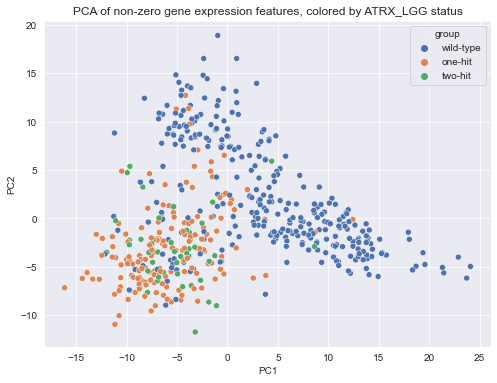

In [24]:
sns.set({'figure.figsize': (8, 6)})

pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(exp_coefs_df)

sns.scatterplot(x=X_proj_pca[:, 0],
                y=X_proj_pca[:, 1],
                hue=sample_mut_df.group,
                hue_order=['wild-type', 'one-hit', 'two-hit'])

plt.title('PCA of non-zero {} features, colored by {} status'.format(
    data_type, identifier))
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 'UMAP2')

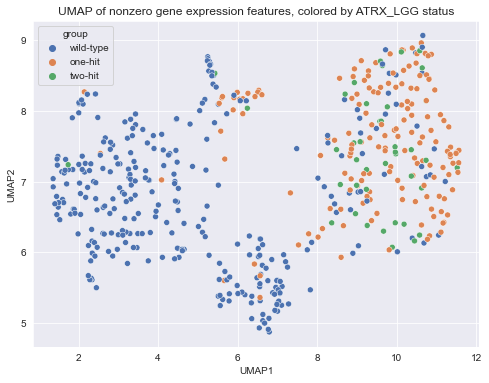

In [25]:
sns.set({'figure.figsize': (8, 6)})

reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(exp_coefs_df)

sns.scatterplot(x=X_proj_umap[:, 0],
                y=X_proj_umap[:, 1],
                hue=sample_mut_df.group,
                hue_order=['wild-type', 'one-hit', 'two-hit'])

plt.title('UMAP of nonzero {} features, colored by {} status'.format(
    data_type, identifier))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')